# Diagnóstico Preliminar para Modelado Espacio-Temporal de PM2.5

Objetivo : preparar insumos para un modelo LUR o predictivo

**Acciones realizadas**

1. **Construcción de matriz de correlación lineal entre variables**
    * Variables: **PM2.5, Humedad, Temperatura**
    * **Script desarrollado**:
    * Cálculo de matriz de correlación (`.corr()` de pandas)
    * Visualización con **mapa de calor (heatmap)** usando Seaborn

2. **Análisis de correlación entre estaciones (PM2.5 series temporales)**
   * Evaluación de similitud entre estaciones mediante correlaciones
   * **Script desarrollado**:
   * Cálculo de matriz de correlación entre estaciones
   * Visualización con **mapa de calor (heatmap)** para identificar patrones comunes y estaciones atípicas

3. **Prueba de estacionariedad (ADF - Augmented Dickey-Fuller)**
   * Aplicada a las series de PM2.5 por estación (ejemplo: Buenos Aires)
   * **Script desarrollado**:
   * Uso de `adfuller()` de `statsmodels`
   * Reporte automático del estadístico ADF, p-value y valores críticos

6. **Análisis de autocorrelación espacial (Índice de Moran)**
   * Medición de autocorrelación espacial de los promedios de PM2.5
   * **Script desarrollado**:
   * Uso de `esda.moran.Moran()` de la librería **PySAL**
   * Reporte de Moran’s I y p-value


Primeras 5 filas del CSV:
                       date    PM25  Humidity  Temperature  \
0 2025-03-01 01:00:00+00:00  17.745    77.936        18.17   
1 2025-03-01 02:00:00+00:00  18.760    78.760        18.00   
2 2025-03-01 03:00:00+00:00  13.200    80.000        18.00   
3 2025-03-01 04:00:00+00:00     NaN       NaN          NaN   
4 2025-03-01 05:00:00+00:00  13.000    80.000        18.00   

                     station  
0  SAM_IE_BuenosAires_306e73  
1  SAM_IE_BuenosAires_306e73  
2  SAM_IE_BuenosAires_306e73  
3  SAM_IE_BuenosAires_306e73  
4  SAM_IE_BuenosAires_306e73  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6902 entries, 0 to 6901
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         6902 non-null   datetime64[ns, UTC]
 1   PM25         5560 non-null   float64            
 2   Humidity     5560 non-null   float64            
 3   Temper

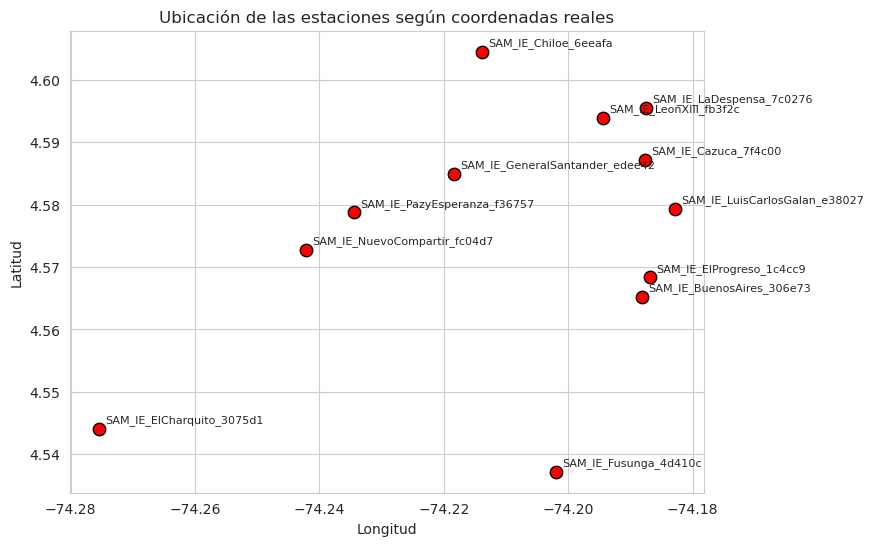


Correlación PM2.5 vs Temperature: nan  p-value: nan
Correlación PM2.5 vs Humidity: nan  p-value: nan

Matriz de correlación global:
                 PM25  Humidity  Temperature
PM25         1.000000  0.178073    -0.058838
Humidity     0.178073  1.000000    -0.784590
Temperature -0.058838 -0.784590     1.000000


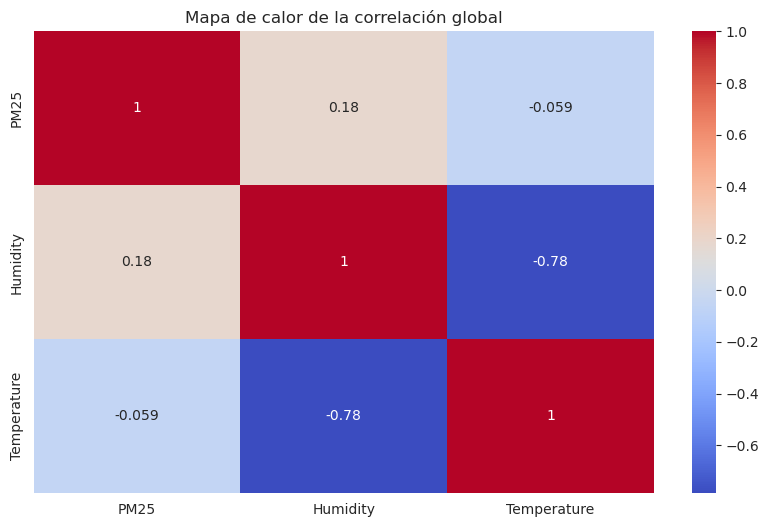

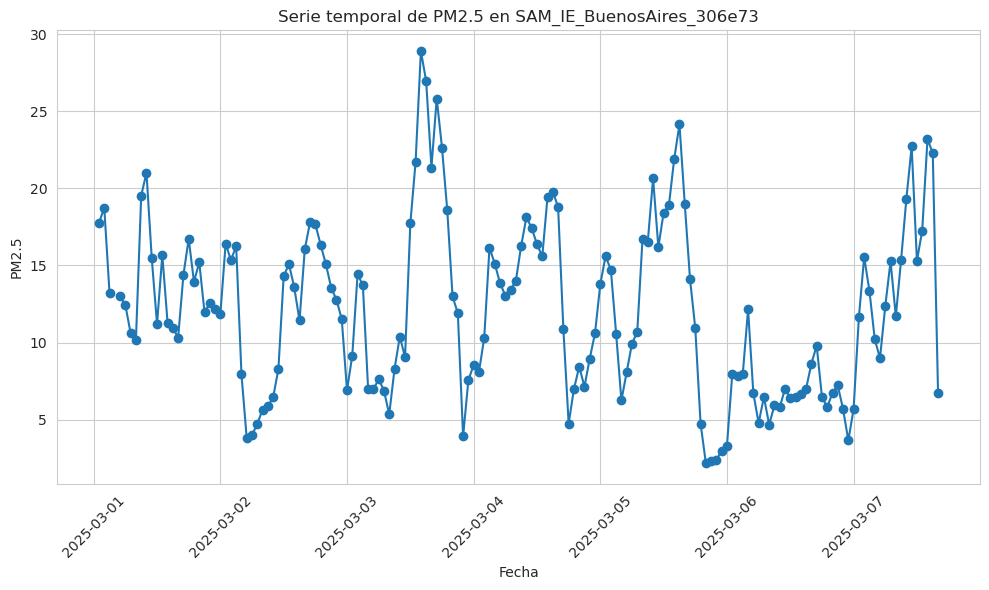


Prueba ADF para PM2.5 en SAM_IE_BuenosAires_306e73:
Estadística ADF: -4.98
p-value: 0.0

Índice global de Moran para PM2.5 (promedio por estación):
Moran's I = -0.214
p-value (norm.) = 0.35


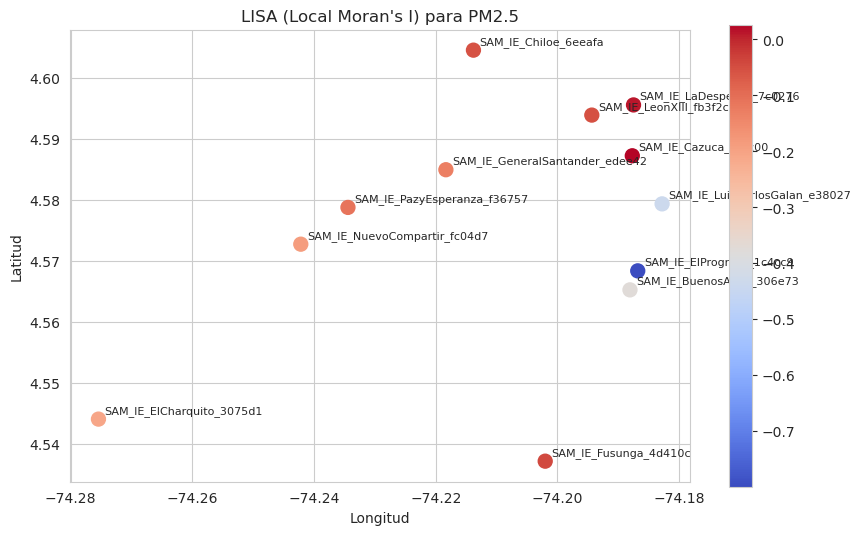


Matriz de correlación entre series temporales de PM2.5 (por estación):
station                         SAM_IE_BuenosAires_306e73  \
station                                                     
SAM_IE_BuenosAires_306e73                        1.000000   
SAM_IE_Cazuca_7f4c00                             0.836164   
SAM_IE_Chiloe_6eeafa                             0.751009   
SAM_IE_ElCharquito_3075d1                        1.000000   
SAM_IE_ElProgreso_1c4cc9                         0.639499   
SAM_IE_Fusunga_4d410c                            0.724556   
SAM_IE_GeneralSantander_edee42                   0.737171   
SAM_IE_LaDespensa_7c0276                         0.734764   
SAM_IE_LeonXIII_fb3f2c                           0.711042   
SAM_IE_LuisCarlosGalan_e38027                    0.809167   
SAM_IE_NuevoCompartir_fc04d7                     0.693085   
SAM_IE_PazyEsperanza_f36757                      0.701681   

station                         SAM_IE_Cazuca_7f4c00  SAM_IE_Chiloe_6eeaf

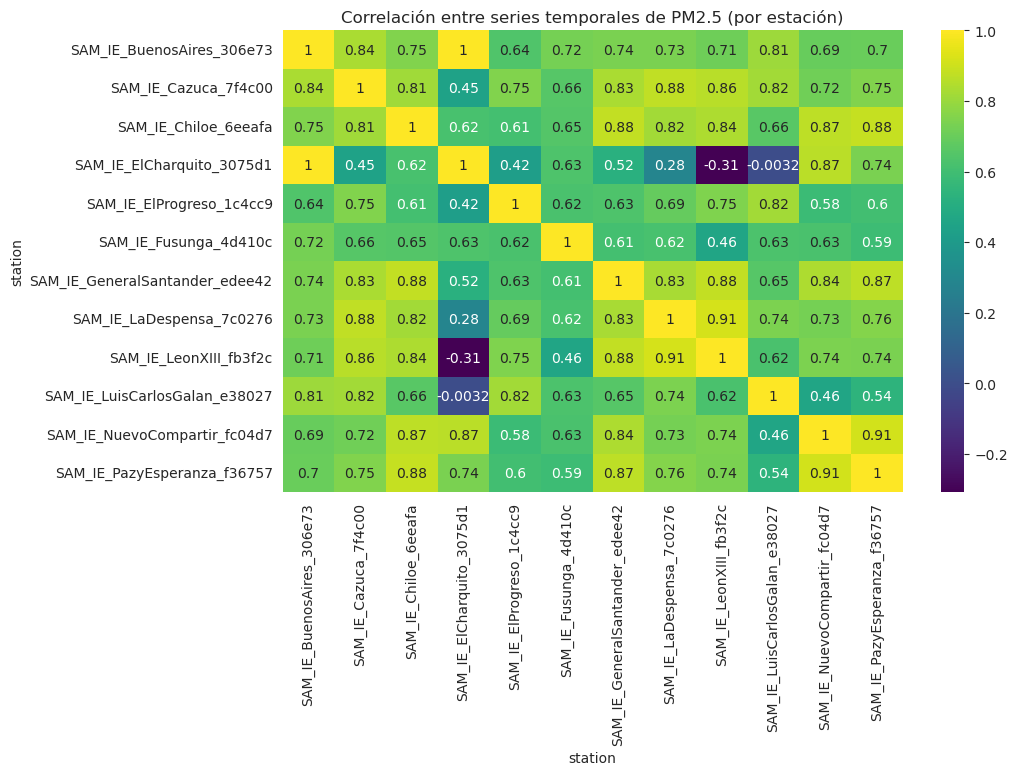

In [1]:
# IMPORTAR LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para análisis temporal (prueba Dickey-Fuller)
import statsmodels.tsa.stattools as ts
from scipy.stats import pearsonr

# Para análisis espacial
import geopandas as gpd
from shapely.geometry import Point
import libpysal as lp
from esda import Moran, Moran_Local

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. CARGAR DATOS DEL MONITOREO (CSV)
df = pd.read_csv("data_MAR_1.csv")
df['date'] = pd.to_datetime(df['date'])
print("Primeras 5 filas del CSV:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

# 2. Resumen estadístico por estación
station_summary = (
    df.groupby("station")
      .agg({
          'PM25': ['mean', 'std', 'min', 'max'],
          'Humidity': ['mean', 'std', 'min', 'max'],
          'Temperature': ['mean', 'std', 'min', 'max']
      })
).reset_index()

# Ajustamos los nombres de columna:
station_summary.columns = ["station", "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
                           "Hum_mean", "Hum_std", "Hum_min", "Hum_max",
                           "Temp_mean", "Temp_std", "Temp_min", "Temp_max"]
print("\nResumen estadístico por estación:")
print(station_summary)

# 3. CARGAR LAS COORDENADAS DESDE EL ARCHIVO EXCEL
# El archivo "Coordenadas_Instituciones.xlsx" tiene la hoja "Hoja1" con columnas "Institución" y "Coordenadas"
df_coords = pd.read_excel("Coordenadas_Instituciones.xlsx", sheet_name="Hoja1")
df_coords.rename(columns={"Estación": "station"}, inplace=True)
print("\nDatos de coordenadas (Excel):")
print(df_coords.head())

# Las coordenadas vienen como una cadena "lat, lon". Separamos y convertimos
def split_coords(s):
    try:
        lat_str, lon_str = s.split(",")
        return float(lat_str.strip()), float(lon_str.strip())
    except:
        return (np.nan, np.nan)

# Creamos dos columnas: lat y lon
df_coords[['lat', 'lon']] = df_coords['Coordenadas'].apply(lambda x: pd.Series(split_coords(x)))
# Renombramos la columna "Institución" para poder hacer merge
df_coords.rename(columns={"Institución":"station"}, inplace=True)
print("\nCoordenadas separadas:")
print(df_coords[['station', 'lat', 'lon']])

# 4. Unir la información de coordenadas con el resumen estadístico por estación
station_summary = station_summary.merge(df_coords[['station', 'lat', 'lon']], on="station", how="left")
print("\nResumen con coordenadas reales:")
print(station_summary[['station', 'PM25_mean', 'lat', 'lon']])

# 5. Crear GeoDataFrame de las estaciones
gdf_stations = gpd.GeoDataFrame(
    station_summary,
    geometry=gpd.points_from_xy(station_summary.lon, station_summary.lat),
    crs="EPSG:4326"
)

# Mapa de las estaciones (con sus identificaciones)
ax = gdf_stations.plot(marker='o', color='red', markersize=80, edgecolor='black')
for idx, row in gdf_stations.iterrows():
    plt.text(row.geometry.x + 0.001, row.geometry.y + 0.001, row['station'], fontsize=8)
plt.title("Ubicación de las estaciones según coordenadas reales")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# 6. ANÁLISIS DE CORRELACIÓN GLOBAL ENTRE VARIABLES
# Correlación global usando el dataset completo (dato a dato)
corr_pm_temp, p_val_pm_temp = pearsonr(df["PM25"], df["Temperature"])
corr_pm_hum, p_val_pm_hum = pearsonr(df["PM25"], df["Humidity"])
print("\nCorrelación PM2.5 vs Temperature:", np.round(corr_pm_temp,3), " p-value:", np.round(p_val_pm_temp,3))
print("Correlación PM2.5 vs Humidity:", np.round(corr_pm_hum,3), " p-value:", np.round(p_val_pm_hum,3))

# Matriz de correlación entre PM2.5, Humidity y Temperature:
corr_matrix = df[['PM25', 'Humidity', 'Temperature']].corr()
print("\nMatriz de correlación global:")
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Mapa de calor de la correlación global")
plt.show()

# 7. ANÁLISIS TEMPORAL EN UNA ESTACIÓN (ejemplo para SAM_IE_BuenosAires_306e73)
df_station = df[df["station"]=="SAM_IE_BuenosAires_306e73"].copy()
df_station = df_station.sort_values("date")
plt.plot(df_station['date'], df_station["PM25"], marker="o")
plt.title("Serie temporal de PM2.5 en SAM_IE_BuenosAires_306e73")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# eliminar  valores faltante (tabla de datos de df_station, los valores de "PM25" no están completos;
#hay múltiples registros con NaN, especialmente visibles en las primeras filas del DataFrame. 
#De hecho, según la información de esa página, la columna "PM25" tiene 5563 valores no nulos de un total de 6905, 
# es decir, 1342 valores faltantes. 
# Esta línea elimina los NaN de la columna "PM25" y permite aplicar correctamente la prueba de Dickey-Fuller.
# Esta línea causa el error:
# adf_result = ts.adfuller(df_station["PM25"])

# Esta es la correcta:
adf_result = ts.adfuller(df_station["PM25"].dropna())
# Prueba de Dickey-Fuller (ADF) para evaluar la estacionariedad de la serie temporal de PM2.5

print("\nPrueba ADF para PM2.5 en SAM_IE_BuenosAires_306e73:")
print("Estadística ADF:", np.round(adf_result[0], 3))
print("p-value:", np.round(adf_result[1], 3))

# Nota: Si el p-value es menor a 0.05 se rechaza la hipótesis nula de no estacionariedad.

# 8. ANÁLISIS ESPACIAL: ÍNDICE GLOBAL DE MORAN y LISA para PM2.5
# Utilizaremos la media PM2.5 por estación (PM25_mean) del GeoDataFrame con coordenadas reales.
# Extraemos las coordenadas en un array (en formato X, Y => lon, lat)
coords_array = station_summary[['lon', 'lat']].to_numpy()

# Construir un peso espacial con vecinos (por ejemplo, 4 vecinos)
w_knn = lp.weights.KNN.from_array(coords_array, k=4)
w_knn.transform = 'r'

# Calcular el índice global de Moran para PM25_mean
moran_global = Moran(station_summary["PM25_mean"].values, w_knn)
print("\nÍndice global de Moran para PM2.5 (promedio por estación):")
print("Moran's I =", np.round(moran_global.I, 3))
print("p-value (norm.) =", np.round(moran_global.p_norm, 3))

# Análisis local (LISA): calcular Local Moran's I
local_moran = Moran_Local(station_summary["PM25_mean"].values, w_knn)
station_summary["LISA_I"] = local_moran.Is
station_summary["LISA_p"] = local_moran.p_sim



# Unir estos índices al GeoDataFrame (si aún no está actualizado)
gdf_stations = gdf_stations.merge(station_summary[["station", "LISA_I", "LISA_p"]], on="station")
ax = gdf_stations.plot(column="LISA_I", cmap="coolwarm", legend=True, markersize=100)
for idx, row in gdf_stations.iterrows():
    plt.text(row.geometry.x+0.001, row.geometry.y+0.001, row["station"], fontsize=8)
plt.title("LISA (Local Moran's I) para PM2.5")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# 9. ANÁLISIS ESPACIOTEMPORAL:
# Se arma una tabla pivote con PM2.5 (cada columna es la serie temporal de una estación) para ver las correlaciones entre series.
df_pivot = df.pivot(index="date", columns="station", values="PM25")
print("\nMatriz de correlación entre series temporales de PM2.5 (por estación):")
corr_stations = df_pivot.corr()
print(corr_stations)
sns.heatmap(corr_stations, annot=True, cmap="viridis")
plt.title("Correlación entre series temporales de PM2.5 (por estación)")
plt.show()

# COMENTARIOS FINALES:
# - Con el agregado de las coordenadas reales, el análisis espacial (global y local) tiene mayor validez.
# - La prueba ADF en la serie temporal de PM2.5 en una estación permite evaluar la estacionariedad temporal.
# - La matriz de correlación "espaciotemporal" (entre series de cada estación) puede apoyar la detección de patrones
#   en la dimensión temporal y la relación entre estaciones.
# - Dependiendo de los resultados, se podría optar por realizar análisis locales (por ejemplo, análisis LISA) o modelos
#   espaciotemporales globales, o inclusive combinar ambos enfoques, según si se observa heterogeneidad local.

In [2]:
print(df_coords.columns)


Index(['Estación', 'Coordenadas', 'lat', 'lon'], dtype='object')


# Conclusiones:
Resumen de los logros y datos más importantes para decisiones

✅ Correlación lineal entre variables meteorológicas:
o	Humedad y temperatura presentan una relación negativa fuerte (r = -0.78), lo que confirma su interacción típica en condiciones atmosféricas.
o	PM2.5 muestra una correlación débil con humedad (r ≈ 0.17) y prácticamente nula con temperatura (r ≈ -0.05), lo que indica que estas variables no explican bien su variabilidad.

✅ Análisis entre estaciones:
o	Alto grado de similitud (r > 0.8) entre varias estaciones, lo que sugiere influencia de factores regionales.
o	Diferencias importantes en estaciones como ElCharquito con correlaciones negativas o nulas, sugiriendo condiciones locales específicas o posibles inconsistencias en la medición.

✅ Prueba de estacionariedad (ADF):
o	Confirmada estacionariedad en la serie de PM2.5 en Buenos Aires (estadístico ADF = -4.98; p-value = 0.0). Esto permite el uso fiable de promedios temporales en el modelo LUR.

✅ Índice de Moran (autocorrelación espacial):
o	No se observa autocorrelación espacial global significativa (Moran’s I = -0.214; p = 0.35). Esto resalta la necesidad de utilizar variables locales en el modelo LUR para explicar mejor la variabilidad espacial.
________________________________________
➡️ Decisión clave: El camino adecuado es implementar un modelo LUR, incorporando variables espaciales detalladas, ya que las variables meteorológicas por sí solas no explican la variabilidad del PM2.5 y no existe un patrón espacial uniforme. Este enfoque permitirá identificar mejor las fuentes e influencias locales sobre los niveles de contaminación.


## 🔜 **Acciones pendientes o recomendadas**

5. **Identificación de estaciones atípicas o inconsistentes**
   * Revisión específica de estaciones con correlaciones negativas o bajas
   * **Script pendiente**: Filtro y visualización individual de esas estaciones

6. **Exploración de relaciones no lineales**
   * Aplicación de regresiones no lineales o técnicas de Machine Learning para evaluar relaciones con PM2.5
   * **Script pendiente**: Aplicación de modelos polinomiales, Random Forest o Gradient Boosting

7. **Análisis local de autocorrelación espacial (LISA)**
   * Para identificar clusters o outliers locales
   * **Script recomendado**: `esda.moran.Moran_Local()` y visualización con `geopandas` o `folium`

8. **Preparación del Modelo LUR (Land Use Regression)**
   * Integración de variables espaciales (uso del suelo, tráfico, etc.)

9 * **Script pendiente**:
     * Preparación de dataset combinado
     * Modelado con `statsmodels` o `sklearn.linear_model.LinearRegression`

📂 Resumen de Scripts desarrollados

| **Nombre/Objetivo del Script**                      | **Librerías principales**             | **Estado**   |
| --------------------------------------------------- | ------------------------------------- | ------------ |
| 📌 **Matriz de correlación lineal**                 | `pandas`, `seaborn`, `matplotlib`     | ✅ Finalizado |
| 📌 **Matriz de correlación entre estaciones PM2.5** | `pandas`, `seaborn`, `matplotlib`     | ✅ Finalizado |
| 📌 **Prueba ADF (estacionariedad)**                 | `statsmodels.tsa.stattools`           | ✅ Finalizado |
| 📌 **Índice de Moran Global**                       | `esda`, `libpysal`, `geopandas`       | ✅ Finalizado |
| 📌 **Análisis local LISA (recomendado)**            | `esda`, `geopandas`, `folium`         | 🔜 Pendiente |
| 📌 **Modelo LUR (regresión espacial)**              | `statsmodels`, `sklearn`, `geopandas` | 🔜 Pendiente |



# Valores Faltantes:
Manejar valores faltantes en series temporales es un paso clave para garantizar análisis confiables, especialmente si planeas hacer pruebas estadísticas como la de Dickey-Fuller o aplicar modelos predictivos. En función del análisis en tu notebook, aquí te explico varias estrategias y cuándo podrías aplicarlas:
# 1. Eliminación directa (dropna())
Cuándo usarlo: Cuando los valores faltantes son pocos y están distribuidos aleatoriamente
entaja: simple y evita imputaciones arbitrarias. ⚠️ Desventaja: podrías perder patrones si los NaN no son aleatorios (por ejemplo, si ocurren siempre en la madrugada).
# 2. Relleno hacia adelante o hacia atrás
Ideal cuando los datos se mantienen relativamente estables entre intervalos:

df["PM25"].fillna(method='ffill', inplace=True)  # forward fill
df["PM25"].fillna(method='bfill', inplace=True)  # backward fill

Útil en estaciones ambientales cuando sensores fallan brevemente.
# Cómo podrías combinarlas de forma segura?
Si ya aplicaste .dropna() y ese fue tu paso final antes de correr la prueba ADF, no necesitamos fillna().

Pero si el objetivo ahora es crear una versión completa de la serie temporal sin perder datos para un análisis posterior (correlaciones, visualización continua, modelado), se podria recargar recargar la columna original con NaN y luego aplicar:

df["PM25"] = df["PM25"].fillna(method='ffill').fillna(method='bfill')
Esto lo hace todo en una sola línea y conserva la continuidad de la serie.

# Analisis de la Matriz de  correlación lineal
La matriz de correlación se usa para analizar la fuerza y la dirección de las relaciones lineales entre las variables del conjunto de datos global. Aquí se incluyen tres variables: PM2.5, Humidity (Humedad) y Temperature (Temperatura).

A continuación, el significado de cada coeficiente:

- **PM2.5 con PM2.5 (1.000000):**  
  Esto es una identidad, ya que cada variable se correlaciona perfectamente consigo misma.

- **PM2.5 con Humidity (0.178073):**  
  Existe una correlación positiva baja entre PM2.5 y la humedad. Esto indica que, a nivel global, cuando la humedad aumenta, los niveles de PM2.5 tienden a subir ligeramente, o viceversa, pero la relación es débil y puede no tener mucha relevancia práctica.

- **PM2.5 con Temperature (-0.058838):**  
  La correlación es prácticamente nula, lo que sugiere que la temperatura y los niveles de PM2.5 no guardan una relación lineal significativa. Es decir, tratamientos basados únicamente en la temperatura no explicarían las variaciones de PM2.5.

- **Humidity con Temperature (-0.784590):**  
  Aquí se observa una fuerte correlación negativa. Esto significa que cuando la temperatura aumenta, la humedad tiende a disminuir considerablemente, y viceversa. Este comportamiento es común en registros meteorológicos, donde las condiciones de aire cálido suelen asociarse con menor humedad.

**Conclusiones generales:**

La matriz de correlación global nos indica que, en este conjunto de datos:

1. **La relación entre variables meteorológicas (humedad y temperatura) es muy marcada**, lo cual puede reflejar las condiciones atmosféricas naturales del área de estudio.  
2. **PM2.5 no muestra una relación lineal fuerte ni con la temperatura ni con la humedad**, lo que sugiere que otros factores (como emisiones de contaminantes, condiciones de dispersión atmosférica, o características locales de la zona) podrían influenciar mejor los niveles de este contaminante.

Esta información es útil para orientar análisis posteriores, pues permite decidir qué variables son potencialmente relevantes para explicar la variación de PM2.5 o si es necesario explorar relaciones no lineales y otros factores contextuales. Por ejemplo, si se desea modelar los niveles de PM2.5, quizás convenga incluir variables adicionales (como datos de tráfico, industria o condiciones atmosféricas específicas) o aplicar técnicas que no se basen únicamente en correlaciones lineales.


# Analisis de la  matriz de Correlación Estaciones

Esta matriz de correlación entre series temporales de PM2.5 por estación nos permite evaluar qué tan similares son los patrones diarios (o en la escala temporal que se maneje) de contaminación en cada estación. Acá te explico en detalle cómo interpretarla:

1. **Diagonal de la matriz (valor 1.0):**  
   Cada estación se correlaciona perfectamente consigo misma. Por eso, en la diagonal siempre aparece el valor 1.0.

2. **Correlaciones altas (valores cercanos a 1):**  
   - Por ejemplo, la correlación entre **SAM_IE_BuenosAires_306e73** y **SAM_IE_Cazuca_7f4c00** es de 0.836, lo que indica que ambas series evolucionan de manera similar: cuando las concentraciones de PM2.5 aumentan en una estación, es muy probable que también lo hagan en la otra.  
   - De forma similar, notarás que muchas de las combinaciones presentan valores mayores a 0.70 o incluso 0.80, lo que sugiere que, en términos generales, los niveles de PM2.5 tienen tendencias compartidas entre varias estaciones.  
     
   Esto puede interpretarse como que existen factores regionales o meteorológicos que afectan a múltiples estaciones de forma coordinada.

3. **Correlaciones moderadas o bajas:**  
   - Por ejemplo, la correlación entre **SAM_IE_ElProgreso_1c4cc9** y **SAM_IE_BuenosAires_306e73** es de 0.639499, un poco más baja, lo que indica cierta diferencia en la evolución temporal de sus concentraciones de PM2.5.
     
   Estos valores nos sugieren que, aunque en muchos casos existen tendencias comunes, algunas estaciones pueden estar sujetas a influencias locales adicionales (como fuentes particulares de emisión o diferencias en la topografía) que hacen que sus series no se muevan de forma tan sincronizada.

4. **Correlaciones negativas o cercanas a cero:**  
   - Un detalle a resaltar es que la serie de **SAM_IE_ElCharquito_3075d1** presenta una correlación negativa significativa con **SAM_IE_LeonXIII_fb3f2c** (-0.309610), y prácticamente nula con **SAM_IE_LuisCarlosGalan_e38027** (-0.003193).  
     
   Estos valores indican que, en esos casos, la evolución de los niveles de PM2.5 en estas estaciones se comporta de manera contraria o sin relación lineal aparente. Esto podría deberse a diferencias en el entorno local, la ubicación (por ejemplo, una zona urbana versus una zona semi-rural) o incluso a variaciones en la metodología de medición/calibración entre estaciones.

5. **Utilidad del análisis:**  
   - **Detección de patrones regionales:** Las correlaciones altas permiten identificar grupos de estaciones que responden de manera similar a los mismos factores climáticos o de dispersión de contaminantes.
   - **Identificación de comportamientos atípicos:** Las estaciones con correlaciones bajas o negativas en relación con el resto pueden requerir un análisis más profundo para determinar si hay problemas en la recolección de datos, calibración de sensores o verdaderas particularidades ambientales.
   - **Posible agrupamiento o clustering:** Con estos datos se pueden aplicar técnicas de clustering para agrupar estaciones con comportamientos similares, lo que facilitaría la modelación espaciotemporal de la contaminación.

En resumen, la matriz de correlación entre series temporales de PM2.5 nos muestra que, en general, muchas de las estaciones experimentan tendencias parecidas en la variación de PM2.5, lo que sugiere factores comunes. No obstante, las discrepancias observadas en algunas correlaciones indican la presencia de influencias o condiciones locales especiales que pueden hacer que el comportamiento de la contaminación en una estación se desvíe del patrón global.


# Analisi de la  estación de Buenos  Aires
 El resultado de la prueba ADF (Augmented Dickey-Fuller) para la serie de PM2.5 en la estación **SAM_IE_BuenosAires_306e73**, con una estadística de -4.98 y un p-value de 0.0, nos indica lo siguiente:

1. **Rechazo de la hipótesis nula de no estacionariedad**  
   La prueba ADF tiene como hipótesis nula que la serie temporal tiene una raíz unitaria, es decir, que es no estacionaria. Un p-value de 0.0 (prácticamente menor a cualquier umbral común, como 0.05) implica que podemos rechazar esa hipótesis nula de forma muy confiable. Esto significa que la serie de PM2.5 en esta estación **es estacionaria**.

2. **Interpretación de la estadística ADF**  
   La estadística ADF de -4.98 es bastante negativa, lo que suele compararse con valores críticos en la prueba. Si la estadística calculada es menor (más negativa) que el valor crítico de referencia, se rechaza la hipótesis nula. En este caso, -4.98 es un valor que, comparado con los valores críticos, confirma que la serie es estacionaria.

3. **Implicaciones prácticas**  
   - **Estacionariedad:** La serie presenta una media y varianza constantes a lo largo del tiempo, lo que facilita el modelado y la predicción utilizando métodos que asumen estacionariedad, como modelos ARMA, ARIMA, entre otros.  
   - **Inferencias robustas:** Al ser estacionaria, los choques o perturbaciones en la serie tienden a ser transitorios y las propiedades estadísticas se mantienen constantes, mejorando la confiabilidad de cualquier análisis temporal o pronóstico basado en estos datos.

En resumen, para la estación SAM_IE_BuenosAires_306e73, el resultado de la prueba ADF indica que la serie de PM2.5 no presenta tendencias o variaciones sistemáticas en sus propiedades estadísticas a lo largo del tiempo, lo cual es una buena noticia para análisis posteriores que requieran series estacionarias. 

# Analisi del Indice  de Moran y P Valor

El índice global de Moran que presentas (Moran's I = -0.214 con p-value = 0.35) se refiere a la autocorrelación espacial de los promedios de PM2.5 por estación, y nos da información sobre cómo se distribuyen espacialmente estos valores. Con este resultado se puede inferir lo siguiente:

1. **Autocorrelación espacial global no significativa:**  
   - El valor de Moran's I de -0.214, negativo, podría interpretarse como una tendencia leve a la dispersión espacial: es decir, en teoría, las estaciones con altos valores de PM2.5 podrían estar próximas a aquellas con valores bajos.  
   - Sin embargo, el p-value de 0.35 indica que esta tendencia no es estadísticamente significativa. En otras palabras, a nivel global no existe evidencia de que los promedios de PM2.5 estén agrupados o dispersos de manera sistemática en el espacio.  
   
2. **Implicaciones para la estacionariedad espacial:**  
   - La falta de significancia en el índice global de Moran sugiere que, a nivel global, la distribución de PM2.5 entre las estaciones se comporta de forma aleatoria, sin presentar un patrón estructurado fuerte.  
   - Esto no implica que la variable PM2.5 sea "estacionaria" en el sentido del análisis temporal (es decir, con media y varianza constantes a lo largo del tiempo), pero sí indica que la variabilidad espacial no sigue una regla de agrupación o dispersión uniforme en toda la región analizada.

3. **Aplicación de un modelo LUR (Land Use Regression):**  
   - El modelo LUR busca relacionar las concentraciones de contaminantes con variables del entorno (como uso de suelo, densidad de tráfico, proximidad a fuentes emisoras, etc.) para explicar la variación espacial.  
   - Dado que el índice global de Moran no muestra una autocorrelación espacial significativa, esto sugiere que el patrón espacial de PM2.5 podría estar fuertemente influenciado por factores locales o heterogéneos, en lugar de seguir un modelo global homogéneo.  
   - Esto respalda la utilización del modelo LUR, ya que implica que es fundamental incluir variables explicativas que capten estas particularidades locales. Aunque a nivel global no se observe un clustering significativo, pueden existir patrones locales (por ejemplo, algunos clusters o outliers) que el LUR puede explicar al incorporar datos relacionados con la actividad urbana, usos del suelo, infraestructura vial, y otros indicadores ambientales específicos de cada área.

**En resumen:**  
El resultado del índice global de Moran indica que, en el grupo de estaciones analizadas, los promedios de PM2.5 no presentan un patrón espacial fuerte y significativo (ya que el p-value es elevado). Esto no desaconseja la aplicación de un modelo predictivo como el LUR, sino que resalta la necesidad de que dicho modelo capture las variaciones locales a través de variables explicativas pertinentes. El enfoque LUR es apropiado en este contexto porque busca explicar la variabilidad de contaminantes usando factores ambientales y del uso del suelo, lo que puede ser fundamental en un escenario donde la autocorrelación espacial global es débil o no significativa.



# Los índices de estacionariedad

Los índices de estacionariedad—como la prueba ADF que se realizó—nos indican que la serie temporal de PM2.5 en la estación estudiada (por ejemplo, **SAM_IE_BuenosAires_306e73**) presenta características constantes a lo largo del tiempo. En otras palabras, la serie no muestra tendencias significativas, cambios abruptos o variaciones estructurales en su media y varianza. Esto es crucial porque, al confirmar la estacionariedad, podemos afirmar que los promedios temporales de PM2.5 son representativos y consistentes, lo que permite utilizarlos en modelos de predicción sin que las variaciones temporales afecten la estabilidad del modelo.

Ahora bien, respecto a la aplicación de un modelo predictivo como el **LUR (Land Use Regression)**, es importante destacar que este tipo de modelo se diseña para explicar la variación espacial de contaminantes a partir de variables del entorno—por ejemplo, uso del suelo, densidad de población, tráfico, tipos de infraestructura, etc. La estacionariedad en la serie temporal es favorable en este contexto porque, al trabajar con promedios o valores resumen por estación, se elimina el factor de tendencias temporales, permitiendo que la variabilidad residual se relacione más directamente con las variables espaciales.

En resumen:

1. **Estacionariedad confirmada:**  
   Los índices (como la estadística ADF) indican que la serie de PM2.5 es estacionaria, lo que significa que los patrones básicos de contaminación se mantienen constantes con el tiempo en cada estación.

2. **Implicación para el modelo LUR:**  
   - Al utilizar promedios estables de PM2.5 por estación, el modelo LUR puede relacionar mejor estas concentraciones con factores geográficos y del entorno.  
   - La ausencia de tendencias temporales evita que la relación entre, por ejemplo, uso del suelo o densidad de tráfico con la contaminación se vea distorsionada por cambios estructurales o fluctuaciones estacionales que no son relevantes para un análisis espacial a largo plazo.

Por lo tanto, **sí**, la confirmación de estacionariedad abre la posibilidad de aplicar un modelo LUR, siempre y cuando se cuente con variables explicativas espaciales de calidad y sean representativas de los procesos que influyen en la generación y dispersión de PM2.5. Este enfoque te permitirá estructurar un modelo predictivo que explique la variabilidad espacial del contaminante basándose en las características del entorno, en lugar de depender de fluctuaciones temporales.

